In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits.qnm as qnm

from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch

from scipy.interpolate import UnivariateSpline
from cmcrameri import cm
from operator import sub

import utils
plt.rcParams.update(utils.rcparams)

In [2]:
def get_aspect(ax):
    # Function used when converting line derivative to rotation angle for the 
    # text labels https://stackoverflow.com/a/42014041
    
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

In [3]:
schwarzschild_data = np.loadtxt('../data/s2l2.dat')

In [4]:
schwarzschild_spectrum = {}
for row in schwarzschild_data:
    omega = (row[0] - 1j*row[1])/2
    n = int(row[3])
    schwarzschild_spectrum[2,n] = omega

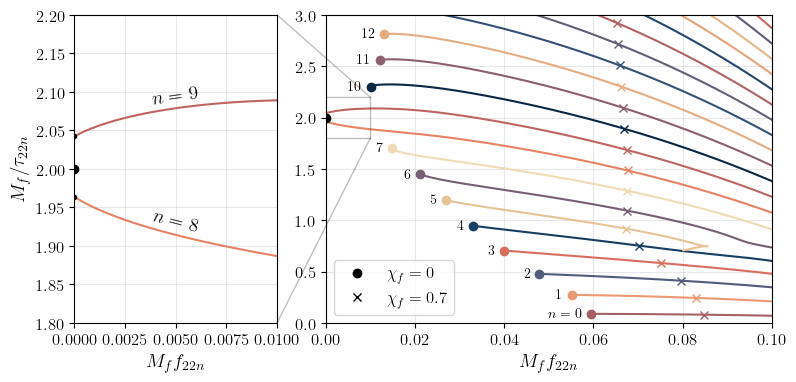

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(9,4), width_ratios=[1,2.2])
fig.subplots_adjust(wspace=0.15)

for ax in axs:
    ax.grid(alpha=0.3)

cmap = cm.lipariS

chi_array_temp = np.linspace(0.1, 0.99, 1000)
indicated_chi = 0.7

for n in range(22):

    lc = cmap(n+2) # cmap(n/21)

    if n == 8:
        c = 'black'
    elif n > 8:
        c = cmap(n+2+1)
    else:
        c = lc

    axs[1].plot(
        np.real(schwarzschild_spectrum[2,n])/(2*np.pi), 
        -np.imag(schwarzschild_spectrum[2,n]), 
        'o', 
        c=c,
        zorder=10
    )

    if n < 12:

        if n == 0:
            text = '$n=0$'
        elif n == 8:
            text = ''
        elif n > 8:
            text = f'${n+1}$'
        else:
            text = f'${n}$'

        axs[1].text(
            np.real(schwarzschild_spectrum[2,n])/(2*np.pi)-0.002, 
            -np.imag(schwarzschild_spectrum[2,n]), 
            text,
            fontsize=10,
            ha='right',
            va='center',
        )

    omega = qnm.omega(2,2,n,1,chi_array_temp)
    chi_array = qnm._interpolated_qnm_funcs[2,2,n][0][0].get_knots()
    omega = qnm.omega(2,2,n,1,chi_array)

    axs[1].plot(
        np.real(omega)/(2*np.pi), 
        -np.imag(omega), 
        c=lc,
    )

    chi_index = np.argmin(np.abs(chi_array-indicated_chi))
    axs[1].plot(
        np.real(omega[chi_index])/(2*np.pi), 
        -np.imag(omega[chi_index]), 
        'x', 
        c=lc,
        zorder=10
    )

inset_xlim = (0, 0.01)
inset_ylim = (1.8, 2.2)

axs[0].set_xlim(inset_xlim)
axs[0].set_ylim(inset_ylim)

aspect = get_aspect(axs[0])

axs[0].plot(
    np.real(schwarzschild_spectrum[2,8])/(2*np.pi), 
    -np.imag(schwarzschild_spectrum[2,8]), 
    'o', 
    c='black',
    zorder=10
)

for n in [8,9]:

    lc = cmap(n+2)

    omega = qnm.omega(2,2,n,1,chi_array_temp)
    chi_array = qnm._interpolated_qnm_funcs[2,2,n][0][0].get_knots()
    omega = qnm.omega(2,2,n,1,chi_array)

    axs[0].plot(
        np.real(omega)/(2*np.pi), 
        -np.imag(omega), 
        c=lc,
    )

    axs[0].plot(
        (np.real(omega)/(2*np.pi))[0], 
        -np.imag(omega)[0], 
        'o',
        markersize=3,
        c='black',
        zorder=10
    )

    omega_spline = UnivariateSpline(np.real(omega)/(2*np.pi), -np.imag(omega), s=0)
    omega_deriv = omega_spline.derivative()

    text_x = 0.005
    rot = np.rad2deg(np.arctan(omega_deriv(text_x)*aspect))

    axs[0].text(
        text_x,
        omega_spline(text_x),
        f'$n={n}$',
        rotation=rot,
        ha='center',
        va='bottom',
    )

fig.add_artist(
    ConnectionPatch(
        xyA=(inset_xlim[1],inset_ylim[1]), 
        coordsA=axs[0].transData, 
        xyB=(inset_xlim[1],inset_ylim[1]), 
        coordsB=axs[1].transData,
        color='k',
        alpha=0.25,
        zorder=10.
        )
    )

fig.add_artist(
    ConnectionPatch(
        xyA=(inset_xlim[1],inset_ylim[0]), 
        coordsA=axs[0].transData, 
        xyB=(inset_xlim[1],inset_ylim[0]), 
        coordsB=axs[1].transData,
        color='k',
        alpha=0.25,
        zorder=10.
        )
    )

box_lw = 1
axs[1].plot(inset_xlim, [inset_ylim[0], inset_ylim[0]], c='k', alpha=0.25, lw=box_lw)
axs[1].plot(inset_xlim, [inset_ylim[1], inset_ylim[1]], c='k', alpha=0.25, lw=box_lw)
axs[1].plot([inset_xlim[1], inset_xlim[1]], inset_ylim, c='k', alpha=0.25, lw=box_lw)

custom_lines = [
    Line2D([0], [0], c='k', marker='o', lw=0),
    Line2D([0], [0], c='k', marker='x', lw=0),
]

axs[1].legend(
    custom_lines, 
    ['$\chi_f = 0$', f'$\chi_f = {indicated_chi}$'], 
    loc='lower left'
)

axs[1].set_xlim(0, 0.1)
axs[1].set_ylim(0., 3.)

axs[1].set_xlabel('$M_f f_{22n}$')
axs[0].set_xlabel('$M_f f_{22n}$')
axs[0].set_ylabel('$M_f/ \\tau_{22n}$')

fig.savefig('figures/qnm_multiplet_taxonomy.png', bbox_inches='tight')